In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import autograd
from abc import ABCMeta, abstractmethod
import kgof.util as util
import kgof.data as data
import kgof.density as density
import kgof
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.glo as glo

import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats
from sklearn.neighbors import kde
from sklearn import mixture

In [4]:
def filter_crimetype(data, type = None):
    if type is None:
        data = data
    else:
        data = data[data[:,0] == type]
    if len(data) == 1:
        print "No Crime Type found"
    else:
        loc = data[:,1:].astype(float)
        loc = np.nan_to_num(loc)
        loc = loc[loc[:,0] != 0]
        #Set City bound
        loc = loc[loc[:,0] >-89]
        loc = loc[loc[:,1] > 40]
        return loc

In [5]:
def run_visual(loc_train, loc_test, size=10000, bin_size = 40):
    #Select Training data X, and Testing data T
    ds = data.DSResample(loc_train)
    dat = ds.sample(size)
    tr, te = dat.split_tr_te(tr_proportion=0.5)
    X = tr.X
    T = te.X
    Total = dat.X
    ds_t = data.DSResample(loc_train)
    T2 = ds.sample(len(X), seed = 9).X

    plt.figure(figsize = (15,8))
    plt.subplot(1,3,1)
    hist = plt.hist2d(X[:,0],X[:,1],bin_size, normed = True)
    plt.title("Distribution of Training Set")

    
    plt.subplot(1,3,2)
    hist = plt.hist2d(T[:,0],T[:,1],bin_size, normed = True)
    plt.title("Distribution of Testing Set")
    
    plt.subplot(1,3,3)
    hist = plt.hist2d(T2[:,0],T2[:,1],bin_size, normed = True)
    plt.title("Distribution of Second Year")
    plt.colorbar()
    
    return X,T,Total,T2

In [6]:
def fit_gmm(X, low = 140, high = 150, inter = 1):
    #Fit mixture of gaussian on X, optimising the number of clusters k using cv on BIC
    bic = []
    lowest_bic = np.infty
    n_components_range = range(low, high)
    cv_types = ['spherical']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=inter*n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [7]:
def run_test(best_gmm, T, J = 1, opt=False, alpha = 0.01, Linear=True):
    # Setup the test on T
    seed = 4
    mean = best_gmm.means_
    variance = best_gmm.covariances_
    weight = best_gmm.weights_
    IsoGM = density.IsoGaussianMixture(means = mean, variances = variance,pmix=weight)
    ds = data.DSResample(T)
    dat = ds.sample(len(T))
    tr, te = dat.split_tr_te(tr_proportion=0.2, seed=seed+1)
    
    gwidth0 = util.meddistance(dat.X, subsample=1000)**2
    null_sim = gof.FSSDH0SimCovObs(n_simulate=1000, seed=10)
    if Linear is True:
        if opt is False:
            # random test locations
            V0 = util.fit_gaussian_draw(dat.X, J, seed=seed+1)
            k0 = kernel.KGauss(gwidth0)
            fssd = gof.FSSD(IsoGM, k0, V0, null_sim=null_sim, alpha=alpha)
            fssd_result = fssd.perform_test(dat)
            return fssd_result
        else:
            opts = {
            'reg': 1e-2,
            'max_iter': 50, 
            'tol_fun':1e-3, 
            'disp':True,
            'gwidth_lb': 5e-3 }
            #Pick V0 randomly from training set to start with 
            idx = np.random.choice(len(dat.X), size=J)
            V0 = dat.X[idx,:]
            V_opt, gw_opt, opt_result = gof.GaussFSSD.optimize_locs_widths(IsoGM, tr, gwidth0, V0, **opts)
            k_opt = kernel.KGauss(gw_opt)
            fssd_opt = gof.FSSD(IsoGM, k_opt, V_opt, null_sim=null_sim, alpha=alpha)
            fssd_opt_result = fssd_opt.perform_test(dat, return_simulated_stats=False)
            return fssd_opt_result, V_opt, gw_opt
        
    else:
        sig2 = util.meddistance(X, subsample=1000)**2
        k = kernel.KGauss(sig2)
        bootstrapper = gof.bootstrapper_rademacher
        kstein = gof.KernelSteinTest(IsoGM, k, bootstrapper=bootstrapper, 
                                     alpha=alpha, n_simulate=1100, seed=seed+1)
        kstein_result = kstein.perform_test(dat, return_simulated_stats=False,
                                           return_ustat_gram=True)
        return kstein_result

In [18]:
def interp_plot(V_opt, T2, X, best_gmm, bin_size = 30):
    plt.figure(figsize = (10,6))
    plt.subplot(1,3,1)
    hist = plt.hist2d(X[:,0],X[:,1],bin_size)
    plt.title("Distribution of Training Set")
    
    plt.subplot(1,3,2)
    x = np.linspace(np.min(X[:,0]), np.max(X[:,0]),100)
    y = np.linspace(np.min(X[:,1]), np.max(X[:,1]),100)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -best_gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    CS = plt.contourf(X, Y, Z)
    plt.title("Fitted Gaussian Mixture")
    
    plt.subplot(1,3,3)
    hist = plt.hist2d(T2[:,0],T2[:,1],bin_size)
    plt.plot(V_opt[:,0], V_opt[:,1], 'w*', markersize=25)
    plt.title("Interpretable Location")
    

In [9]:
def power_check(loc, bmm=None, size = 5000, itr=10, n_components = 146, \
                inter=1, alpha = 0.05, opt=False, quadratic = False):
    rej = 0
    rej_quad = 0
    for i in range(itr):
        ds = data.DSResample(loc)
        dat = ds.sample(size)
        tr, te = dat.split_tr_te(tr_proportion=0.5)
        if bmm is None:
            best_gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type='spherical')
            best_gmm.fit(tr.X)
        else:
            best_gmm = bmm
        fssd = run_test(best_gmm, te.X, opt=opt, alpha = alpha)
        if opt is False:
            rej += fssd['h0_rejected']
        else:
            rej += fssd[0]['h0_rejected']
        
        if quadratic is True:
            fssd = fssd = run_test(best_gmm, te.X, opt=opt, alpha = alpha,Linear=False)
            rej_quad += fssd['h0_rejected']
    if quadratic is False:
        return rej
    else:
        return rej, rej_quad

In [10]:
# dd = pd.read_csv('/home/wenkai/Downloads/Crimes_-_2015.csv')
# dd14 = pd.read_csv('/home/wenkai/Downloads/Crimes_-_2014.csv')
dd = np.load(glo.data_file('chicago_crime_loc_with_type2015.npz'))['data']
dd14 = np.load(glo.data_file('chicago_crime_loc_with_type2014.npz'))['data']

In [11]:
from collections import Counter
def crime_count(data, n=10000):
    z = data[:,0]
    count = Counter(z)
    interest = []
    for i in enumerate(count):
        if count[i[1]] > n:
            interest.append([i[1],count[i[1]]])
    return interest
interest2014 = crime_count(dd14)
interest2015 = crime_count(dd)
print '2014:', interest2014
print '2015:',interest2015

2014: [['BURGLARY', 14569], ['OTHER OFFENSE', 16969], ['CRIMINAL DAMAGE', 27798], ['THEFT', 61536], ['NARCOTICS', 28974], ['DECEPTIVE PRACTICE', 15372], ['BATTERY', 49446], ['ASSAULT', 16896]]
2015: [['BURGLARY', 13182], ['OTHER OFFENSE', 17537], ['CRIMINAL DAMAGE', 28671], ['THEFT', 57307], ['NARCOTICS', 23837], ['DECEPTIVE PRACTICE', 15522], ['BATTERY', 48909], ['MOTOR VEHICLE THEFT', 10073], ['ASSAULT', 17041]]


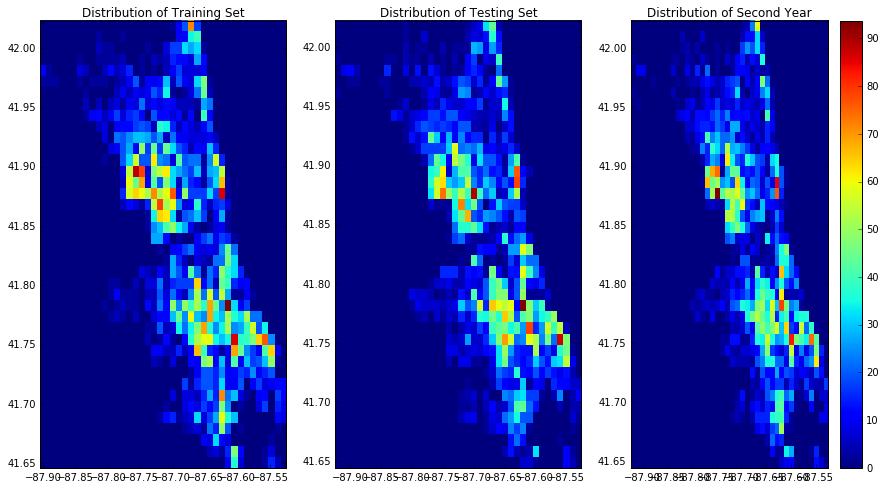

In [12]:
c_type = 'ASSAULT'
size = 10000
loc14 = filter_crimetype(dd14, c_type)
loc15 = filter_crimetype(dd, c_type)
X,T,Total,T2 = run_visual(loc14,loc15,size=size, bin_size=40)

In [ ]:
#Build the gmm model
best_gmm = fit_gmm(X,low = 34, high = 69, inter=1)
n_comp = best_gmm.n_components
best_gmm

In [ ]:
#Test this year
fssd_this_year = run_test(best_gmm,T,opt=False)
fssd_this_year

In [ ]:
iteration = 30
rej = power_check(loc14, size = size, itr = iteration, n_components = n_comp,\
                  inter=1, alpha = 0.05, opt=True, quadratic = True)
rej_rate_linear = rej[0]/float(iteration)
rej_rate_quad = rej[1]/float(iteration)
print rej_rate_linear, rej_rate_quad

In [14]:
best_gmm = mixture.GaussianMixture(n_components=n_comp, covariance_type='spherical')
best_gmm.fit(Total)

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=38, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [15]:
#Test next year
fssd_next_year = run_test(best_gmm, T2)
fssd_next_year

{'alpha': 0.01,
 'h0_rejected': True,
 'n_simulate': 1000,
 'pvalue': 0.001,
 'test_stat': 6953.1731317872373,
 'time_secs': 0.08795881271362305}

In [16]:
#Test next year
fssd_next_year_opt, V_opt, gw_opt = run_test(best_gmm, T2, J=1, opt=True)
fssd_next_year_opt

{'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 1000,
 'pvalue': 0.623,
 'test_stat': -2.3476219158929514,
 'time_secs': 0.05766701698303223}

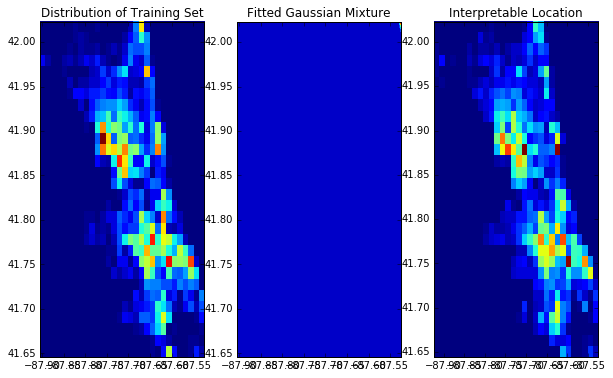

In [19]:
interp_plot(V_opt,T2,X, best_gmm = best_gmm)

In [ ]:
np.savez('chicago_'+str(c_type)+'comparison_with'+str(n_comp)+'GMM'+'.npz',\
         crime_type = c_type, V_opt = V_opt, power_iteration = iteration, \
         n_comp = n_comp, iteration = iteration, rej_rate = rej_rate_linear, gw_opt = gw_opt,\
         fssd_this_year = fssd_this_year, fssd_next_year = fssd_next_year, fssd_next_year_opt = fssd_next_year_opt)         